In [1]:
# just here
%load_ext autoreload
%autoreload 2

In [ ]:
# imports
import matplotlib.pyplot as plt
import iblphotometry.io as ffio

In [ ]:
# ONE instantiation
from one.api import ONE

one = ONE(base_url='https://alyx.internationalbrainlab.org', mode='remote')

# an example eid
lab = 'wittenlab'
eids = one.search(dataset='photometry.signal.pqt', lab=lab)
eid = eids[26]

In [12]:
# loading data
raw_photometry_df = one.load_dataset(eid, dataset='photometry.signal')
locations_df = one.load_dataset(eid, dataset='photometryROI.locations')
trials = one.load_dataset(eid, '*trials.table')
raw_dfs = ffio.from_ibl_dataframes(raw_photometry_df, locations_df)
raw_dfs

{'GCaMP':                    DMS       DLS      NAcc
 times                                     
 -26.104571    0.003983  0.006191  0.003983
 -26.084607    0.003922  0.004078  0.003922
 -26.064644    0.004022  0.005881  0.003977
 -26.044680    0.004055  0.005767  0.003976
 -26.024717    0.004078  0.005803  0.003976
 ...                ...       ...       ...
  3877.629817  0.003965  0.005286  0.003927
  3877.649819  0.003958  0.005281  0.003944
  3877.669853  0.003970  0.005352  0.003936
  3877.689887  0.003962  0.005330  0.003934
  3877.709921  0.003968  0.005397  0.003939
 
 [195198 rows x 3 columns]}

from this data representation, running an processing pipeline is simple 

In [13]:
from iblphotometry import pipelines

# a single band pipelines
pipeline = pipelines.sliding_mad_pipeline

# getting the data for the GCaMP channel
raw_df = raw_dfs['GCaMP']

# restricting the photometry data to the time of the task +- 10 seconds
t_start = trials['intervals_0'].iloc[0] - 10
t_stop = trials['intervals_1'].iloc[-1] + 10
raw_df = raw_df.loc[t_start:t_stop]

df_processed = pipelines.run_pipeline(pipeline, raw_df)
df_processed

,DMS,DLS,NAcc
-9.994494,0.502134,0.472474,0.072365
-9.974530,-0.270563,0.416623,0.282271
-9.954567,-0.054550,0.349578,0.406404
-9.934604,-0.870414,0.247359,0.034610
-9.914640,-0.998413,0.149933,0.044276
...,...,...,...
3877.629817,-0.307573,-0.209454,-0.947464
3877.649819,-0.449528,-0.220531,0.437115
3877.669853,-0.218852,-0.074683,-0.255174
3877.689887,-0.378551,-0.118991,-0.409016


Pipelines are lists of tuples, where each tuple defines a `callable` pipeline function and a `dict` of its arguments. Each function is executed one after another, and the output of a function is fed into the next. This makes pipelines very modular they can be constructed with a lot of flexibility:

In [19]:
from iblphotometry import processing as fpp

pipeline = (
    (fpp.remove_spikes, dict(sd=5)),
    (
        fpp.lowpass_bleachcorrect,
        dict(),
    ),  # if an empty dict is passed, the default values will be used
    (fpp.zscore, dict(mode='median')),
)

df_processed = pipelines.run_pipeline(pipeline, raw_df)
df_processed

,DMS,DLS,NAcc
-9.994494,0.588976,0.461625,-0.300992
-9.974530,-0.501257,0.408888,0.213176
-9.954567,-0.196467,0.345582,0.517156
-9.934604,-1.347421,0.249063,-0.393311
-9.914640,-1.527899,0.157071,-0.369591
...,...,...,...
3877.629817,-0.258024,-0.168823,-0.202499
3877.649819,-0.384000,-0.178980,0.231208
3877.669853,-0.179288,-0.045244,0.014355
3877.689887,-0.321012,-0.085873,-0.033835


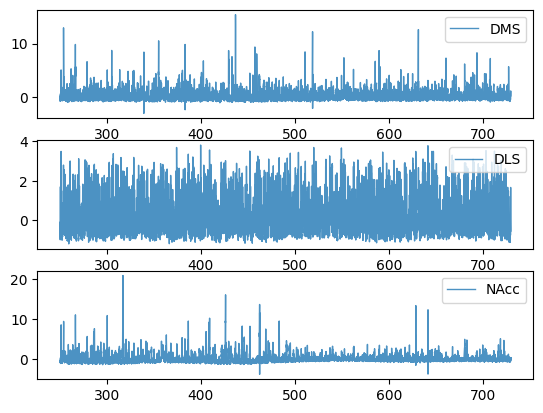

In [18]:
t_start = trials['intervals_0'].iloc[0] + 250
t_stop = t_start + 480
cols = df_processed.columns
fig, axes = plt.subplots(nrows=len(cols))
for i, col in enumerate(cols):
    axes[i].plot(df_processed[col].loc[t_start:t_stop], label=col, alpha=0.8, lw=1)
    axes[i].legend()